In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

balanced_path_data = 'drive/MyDrive/balanced_csic_data_128/training'
imbalanced_path_data = 'drive/MyDrive/imbalanced_csic_data_128/training'

feature_extract = True

In [4]:
mean = torch.tensor([135.31470632, 124.53849418, 103.39646082])
std = torch.tensor([5.18153318, 4.14170719, 5.17011963])

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [5]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# load the balanced dataset
balanced_dataset = datasets.ImageFolder(balanced_path_data, transform=transform)
balanced_datasets = train_val_dataset(balanced_dataset)

# #load the imbalanced dataset
# imbalanced_dataset = datasets.ImageFolder(imbalanced_path_data, transform=transform)
# imbalanced_datasets = train_val_dataset(imbalanced_dataset)

class_dict = balanced_dataset.class_to_idx

In [6]:
batch_size = 32
balanced_dataloaders_dict = {x: torch.utils.data.DataLoader(balanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
#imbalanced_dataloaders_dict = {x: torch.utils.data.DataLoader(imbalanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}


In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [8]:
# data_iter = iter(dataloaders_dict['train'])
# images, labels = next(data_iter)

In [9]:
from tqdm import trange
from tqdm import tqdm

In [10]:
# def getCategoricalAccuracy(pred, true, class_names:dict):
#   for cl in class_names.keys():
#     class_id = int(class_names[cl])
#     locs = np.where(np.array(true)==class_id)
#     class_acc = sum(pred[locs] == int(class_id))/len(locs)
#     print('Accuracy for {}:{}'.format(str(cl), class_acc))

def train_model(model, dataloaders, criterion, optimizer, num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase],unit = 'batch') as tepoch:
              # Iterate over data.
              for inputs, labels in tepoch:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      # Special case for inception because in training it has an auxiliary output. In train
                      #   mode we calculate the loss by summing the final output and the auxiliary output
                      #   but in testing we only consider the final output.
                      if is_inception and phase == 'train':
                          # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                          outputs, aux_outputs = model(inputs)
                          loss1 = criterion(outputs, labels)
                          loss2 = criterion(aux_outputs, labels)
                          loss = loss1 + 0.4*loss2
                      else:
                          outputs = model(inputs)
                          loss = criterion(outputs, labels)

                      _, preds = torch.max(outputs, 1)
                      

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  #getCategoricalAccuracy(preds, labels.data, class_dict)
                  running_corrects += torch.sum(preds == labels.data)

              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase == 'val':
                  val_acc_history.append(epoch_acc)
              if phase == 'train':
                  train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
model_ft_balanced = models.resnet18(pretrained=False)
set_parameter_requires_grad(model_ft_balanced, True)
model_ft_balanced.fc = nn.Linear(512, len(balanced_dataset.class_to_idx))
input_size = 224

model_ft_balanced = model_ft_balanced.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Setup the loss fxn
import time
import copy
criterion = nn.CrossEntropyLoss()
epoch = 50

# Train and evaluate - balanced
model_ft_balanced, balanced_val_hist, balanced_tr_hist  = train_model(model_ft_balanced, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 42/42 [01:28<00:00,  2.10s/batch]


train Loss: 1.0269 Acc: 0.6772


100%|██████████| 5/5 [00:11<00:00,  2.23s/batch]


val Loss: 1.0083 Acc: 0.6351

Epoch 1/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.18batch/s]


train Loss: 0.9304 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.65batch/s]


val Loss: 0.9779 Acc: 0.6351

Epoch 2/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.09batch/s]


train Loss: 0.9265 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.45batch/s]


val Loss: 0.9788 Acc: 0.6351

Epoch 3/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.07batch/s]


train Loss: 0.9263 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.98batch/s]


val Loss: 0.9755 Acc: 0.6351

Epoch 4/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.35batch/s]


train Loss: 0.9282 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.47batch/s]


val Loss: 0.9728 Acc: 0.6351

Epoch 5/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.54batch/s]


train Loss: 0.9306 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.22batch/s]


val Loss: 0.9758 Acc: 0.6351

Epoch 6/49
----------


100%|██████████| 42/42 [00:07<00:00,  5.83batch/s]


train Loss: 0.9294 Acc: 0.6772


100%|██████████| 5/5 [00:01<00:00,  4.54batch/s]


val Loss: 0.9747 Acc: 0.6351

Epoch 7/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.65batch/s]


train Loss: 0.9261 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.57batch/s]


val Loss: 0.9765 Acc: 0.6351

Epoch 8/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.17batch/s]


train Loss: 0.9260 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.45batch/s]


val Loss: 0.9763 Acc: 0.6351

Epoch 9/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.26batch/s]


train Loss: 0.9257 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.55batch/s]


val Loss: 0.9762 Acc: 0.6351

Epoch 10/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.08batch/s]


train Loss: 0.9251 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.34batch/s]


val Loss: 0.9737 Acc: 0.6351

Epoch 11/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.17batch/s]


train Loss: 0.9250 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.35batch/s]


val Loss: 0.9769 Acc: 0.6351

Epoch 12/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.20batch/s]


train Loss: 0.9284 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.53batch/s]


val Loss: 0.9752 Acc: 0.6351

Epoch 13/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.14batch/s]


train Loss: 0.9255 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.27batch/s]


val Loss: 0.9754 Acc: 0.6351

Epoch 14/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.14batch/s]


train Loss: 0.9261 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.31batch/s]


val Loss: 0.9769 Acc: 0.6351

Epoch 15/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.13batch/s]


train Loss: 0.9249 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.47batch/s]


val Loss: 0.9724 Acc: 0.6351

Epoch 16/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.10batch/s]


train Loss: 0.9261 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.25batch/s]


val Loss: 0.9731 Acc: 0.6351

Epoch 17/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.40batch/s]


train Loss: 0.9249 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.70batch/s]


val Loss: 0.9732 Acc: 0.6351

Epoch 18/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.89batch/s]


train Loss: 0.9262 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.11batch/s]


val Loss: 0.9742 Acc: 0.6351

Epoch 19/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.92batch/s]


train Loss: 0.9243 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.84batch/s]


val Loss: 0.9771 Acc: 0.6351

Epoch 20/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.06batch/s]


train Loss: 0.9271 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.48batch/s]


val Loss: 0.9703 Acc: 0.6351

Epoch 21/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.08batch/s]


train Loss: 0.9252 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.43batch/s]


val Loss: 0.9728 Acc: 0.6351

Epoch 22/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.15batch/s]


train Loss: 0.9247 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.32batch/s]


val Loss: 0.9746 Acc: 0.6351

Epoch 23/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.98batch/s]


train Loss: 0.9240 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.25batch/s]


val Loss: 0.9730 Acc: 0.6351

Epoch 24/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.15batch/s]


train Loss: 0.9249 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.60batch/s]


val Loss: 0.9706 Acc: 0.6351

Epoch 25/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.07batch/s]


train Loss: 0.9236 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.39batch/s]


val Loss: 0.9726 Acc: 0.6351

Epoch 26/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.00batch/s]


train Loss: 0.9230 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.19batch/s]


val Loss: 0.9754 Acc: 0.6351

Epoch 27/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.06batch/s]


train Loss: 0.9278 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.46batch/s]


val Loss: 0.9742 Acc: 0.6351

Epoch 28/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.15batch/s]


train Loss: 0.9241 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.22batch/s]


val Loss: 0.9764 Acc: 0.6351

Epoch 29/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.16batch/s]


train Loss: 0.9234 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.49batch/s]


val Loss: 0.9718 Acc: 0.6351

Epoch 30/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.05batch/s]


train Loss: 0.9236 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.09batch/s]


val Loss: 0.9730 Acc: 0.6351

Epoch 31/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.10batch/s]


train Loss: 0.9229 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.37batch/s]


val Loss: 0.9684 Acc: 0.6351

Epoch 32/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.89batch/s]


train Loss: 0.9237 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.59batch/s]


val Loss: 0.9744 Acc: 0.6351

Epoch 33/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.40batch/s]


train Loss: 0.9236 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.17batch/s]


val Loss: 0.9792 Acc: 0.6351

Epoch 34/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.88batch/s]


train Loss: 0.9232 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.12batch/s]


val Loss: 0.9692 Acc: 0.6351

Epoch 35/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.94batch/s]


train Loss: 0.9224 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.08batch/s]


val Loss: 0.9855 Acc: 0.6351

Epoch 36/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.04batch/s]


train Loss: 0.9257 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.47batch/s]


val Loss: 0.9775 Acc: 0.6351

Epoch 37/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.98batch/s]


train Loss: 0.9224 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.49batch/s]


val Loss: 0.9697 Acc: 0.6351

Epoch 38/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.09batch/s]


train Loss: 0.9241 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.42batch/s]


val Loss: 0.9657 Acc: 0.6351

Epoch 39/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.92batch/s]


train Loss: 0.9241 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.40batch/s]


val Loss: 0.9726 Acc: 0.6351

Epoch 40/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.99batch/s]


train Loss: 0.9231 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.49batch/s]


val Loss: 0.9752 Acc: 0.6351

Epoch 41/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.13batch/s]


train Loss: 0.9215 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.18batch/s]


val Loss: 0.9676 Acc: 0.6351

Epoch 42/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.09batch/s]


train Loss: 0.9232 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.09batch/s]


val Loss: 0.9687 Acc: 0.6351

Epoch 43/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.95batch/s]


train Loss: 0.9213 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.11batch/s]


val Loss: 0.9775 Acc: 0.6351

Epoch 44/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.87batch/s]


train Loss: 0.9228 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.40batch/s]


val Loss: 0.9670 Acc: 0.6351

Epoch 45/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.01batch/s]


train Loss: 0.9234 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.31batch/s]


val Loss: 0.9650 Acc: 0.6351

Epoch 46/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.06batch/s]


train Loss: 0.9218 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.37batch/s]


val Loss: 0.9753 Acc: 0.6351

Epoch 47/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.28batch/s]


train Loss: 0.9227 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.28batch/s]


val Loss: 0.9672 Acc: 0.6351

Epoch 48/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.73batch/s]


train Loss: 0.9228 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.36batch/s]


val Loss: 0.9695 Acc: 0.6351

Epoch 49/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.99batch/s]


train Loss: 0.9214 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  8.46batch/s]

val Loss: 0.9655 Acc: 0.6351

Training complete in 5m 45s
Best val Acc: 0.635135


In [13]:
# model_ft_imbalanced = models.resnet18(pretrained=True)
# set_parameter_requires_grad(model_ft_imbalanced, True)
# model_ft_imbalanced.fc = nn.Linear(512, len(class_dict))
# input_size = 224

# model_ft_imbalanced = model_ft_imbalanced.to(device)

# # Gather the parameters to be optimized/updated in this run. If we are
# #  finetuning we will be updating all parameters. However, if we are
# #  doing feature extract method, we will only update the parameters
# #  that we have just initialized, i.e. the parameters with requires_grad
# #  is True.
# params_to_update = model_ft_imbalanced.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft_imbalanced.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft_imbalanced.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# # Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params_to_update, lr=0.00001)
# Train and evaluate - imbalanced
# model_ft_imbalanced, imbalanced_val_hist, imbalanced_tr_hist  = train_model(model_ft_imbalanced, imbalanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

In [14]:
#ResNet 50
model_ft_balanced2 = models.resnet50(pretrained=False)
set_parameter_requires_grad(model_ft_balanced2, True)
model_ft_balanced2.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced2 = model_ft_balanced2.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Training a pretrained Resnet50 on a balanced dataset
model_ft_balanced2, balanced_val_hist2, balanced_tr_hist2  = train_model(model_ft_balanced2, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.96batch/s]


train Loss: 0.9588 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.31batch/s]


val Loss: 0.9772 Acc: 0.6351

Epoch 1/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.13batch/s]


train Loss: 0.9379 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.13batch/s]


val Loss: 0.9754 Acc: 0.6351

Epoch 2/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.12batch/s]


train Loss: 0.9270 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.45batch/s]


val Loss: 0.9688 Acc: 0.6351

Epoch 3/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.11batch/s]


train Loss: 0.9243 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.56batch/s]


val Loss: 0.9584 Acc: 0.6351

Epoch 4/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.17batch/s]


train Loss: 0.9253 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.53batch/s]


val Loss: 0.9788 Acc: 0.6351

Epoch 5/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.04batch/s]


train Loss: 0.9270 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.42batch/s]


val Loss: 0.9490 Acc: 0.6351

Epoch 6/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.04batch/s]


train Loss: 0.9090 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.39batch/s]


val Loss: 0.9654 Acc: 0.6351

Epoch 7/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.17batch/s]


train Loss: 0.9033 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.54batch/s]


val Loss: 0.9333 Acc: 0.6351

Epoch 8/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.18batch/s]


train Loss: 0.8983 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.50batch/s]


val Loss: 0.9221 Acc: 0.6351

Epoch 9/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.15batch/s]


train Loss: 0.9033 Acc: 0.6780


100%|██████████| 5/5 [00:00<00:00,  7.43batch/s]


val Loss: 0.9199 Acc: 0.6351

Epoch 10/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.10batch/s]


train Loss: 0.8933 Acc: 0.6780


100%|██████████| 5/5 [00:00<00:00,  7.29batch/s]


val Loss: 0.9121 Acc: 0.6351

Epoch 11/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.20batch/s]


train Loss: 0.8845 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.47batch/s]


val Loss: 0.9321 Acc: 0.6351

Epoch 12/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.14batch/s]


train Loss: 0.8874 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.27batch/s]


val Loss: 0.9120 Acc: 0.6351

Epoch 13/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.06batch/s]


train Loss: 0.8808 Acc: 0.6780


100%|██████████| 5/5 [00:00<00:00,  7.50batch/s]


val Loss: 0.9056 Acc: 0.6351

Epoch 14/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.06batch/s]


train Loss: 0.8820 Acc: 0.6795


100%|██████████| 5/5 [00:00<00:00,  7.46batch/s]


val Loss: 0.8859 Acc: 0.6351

Epoch 15/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.10batch/s]


train Loss: 0.8780 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.36batch/s]


val Loss: 0.8896 Acc: 0.6351

Epoch 16/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.98batch/s]


train Loss: 0.8706 Acc: 0.6817


100%|██████████| 5/5 [00:00<00:00,  7.32batch/s]


val Loss: 0.8956 Acc: 0.6351

Epoch 17/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.07batch/s]


train Loss: 0.8651 Acc: 0.6787


100%|██████████| 5/5 [00:00<00:00,  7.28batch/s]


val Loss: 0.8934 Acc: 0.6554

Epoch 18/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.21batch/s]


train Loss: 0.8749 Acc: 0.6908


100%|██████████| 5/5 [00:00<00:00,  7.59batch/s]


val Loss: 0.9010 Acc: 0.6351

Epoch 19/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.11batch/s]


train Loss: 0.8625 Acc: 0.6817


100%|██████████| 5/5 [00:00<00:00,  7.62batch/s]


val Loss: 0.8664 Acc: 0.6554

Epoch 20/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.14batch/s]


train Loss: 0.8725 Acc: 0.6848


100%|██████████| 5/5 [00:00<00:00,  7.40batch/s]


val Loss: 0.8628 Acc: 0.6486

Epoch 21/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.19batch/s]


train Loss: 0.8608 Acc: 0.6878


100%|██████████| 5/5 [00:00<00:00,  7.34batch/s]


val Loss: 0.8683 Acc: 0.6351

Epoch 22/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.12batch/s]


train Loss: 0.8564 Acc: 0.6817


100%|██████████| 5/5 [00:00<00:00,  7.27batch/s]


val Loss: 0.8610 Acc: 0.6622

Epoch 23/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.02batch/s]


train Loss: 0.8630 Acc: 0.6931


100%|██████████| 5/5 [00:00<00:00,  7.15batch/s]


val Loss: 0.8604 Acc: 0.6554

Epoch 24/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.14batch/s]


train Loss: 0.8612 Acc: 0.6893


100%|██████████| 5/5 [00:00<00:00,  7.56batch/s]


val Loss: 0.8585 Acc: 0.6554

Epoch 25/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.17batch/s]


train Loss: 0.8497 Acc: 0.6885


100%|██████████| 5/5 [00:00<00:00,  7.33batch/s]


val Loss: 0.8625 Acc: 0.6959

Epoch 26/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.22batch/s]


train Loss: 0.8565 Acc: 0.6893


100%|██████████| 5/5 [00:00<00:00,  7.52batch/s]


val Loss: 0.8543 Acc: 0.6486

Epoch 27/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.12batch/s]


train Loss: 0.8469 Acc: 0.6931


100%|██████████| 5/5 [00:00<00:00,  7.52batch/s]


val Loss: 0.8451 Acc: 0.6622

Epoch 28/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.09batch/s]


train Loss: 0.8462 Acc: 0.6946


100%|██████████| 5/5 [00:00<00:00,  7.49batch/s]


val Loss: 0.8605 Acc: 0.6622

Epoch 29/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.89batch/s]


train Loss: 0.8442 Acc: 0.6961


100%|██████████| 5/5 [00:00<00:00,  7.33batch/s]


val Loss: 0.8458 Acc: 0.6824

Epoch 30/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.93batch/s]


train Loss: 0.8442 Acc: 0.7021


100%|██████████| 5/5 [00:00<00:00,  7.38batch/s]


val Loss: 0.8506 Acc: 0.6554

Epoch 31/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.01batch/s]


train Loss: 0.8426 Acc: 0.6953


100%|██████████| 5/5 [00:00<00:00,  7.53batch/s]


val Loss: 0.8421 Acc: 0.7230

Epoch 32/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.00batch/s]


train Loss: 0.8474 Acc: 0.6976


100%|██████████| 5/5 [00:00<00:00,  7.44batch/s]


val Loss: 0.8396 Acc: 0.6757

Epoch 33/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.11batch/s]


train Loss: 0.8449 Acc: 0.6998


100%|██████████| 5/5 [00:00<00:00,  7.59batch/s]


val Loss: 0.8395 Acc: 0.6959

Epoch 34/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.99batch/s]


train Loss: 0.8408 Acc: 0.7006


100%|██████████| 5/5 [00:00<00:00,  7.34batch/s]


val Loss: 0.8384 Acc: 0.6757

Epoch 35/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.98batch/s]


train Loss: 0.8401 Acc: 0.7066


100%|██████████| 5/5 [00:00<00:00,  7.64batch/s]


val Loss: 0.8415 Acc: 0.6622

Epoch 36/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.11batch/s]


train Loss: 0.8404 Acc: 0.7044


100%|██████████| 5/5 [00:00<00:00,  7.46batch/s]


val Loss: 0.8502 Acc: 0.6622

Epoch 37/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.11batch/s]


train Loss: 0.8367 Acc: 0.6991


100%|██████████| 5/5 [00:00<00:00,  7.42batch/s]


val Loss: 0.8487 Acc: 0.7162

Epoch 38/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.02batch/s]


train Loss: 0.8385 Acc: 0.7036


100%|██████████| 5/5 [00:00<00:00,  7.44batch/s]


val Loss: 0.8339 Acc: 0.6689

Epoch 39/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.11batch/s]


train Loss: 0.8394 Acc: 0.7006


100%|██████████| 5/5 [00:00<00:00,  7.31batch/s]


val Loss: 0.8575 Acc: 0.6757

Epoch 40/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.14batch/s]


train Loss: 0.8430 Acc: 0.7051


100%|██████████| 5/5 [00:00<00:00,  7.22batch/s]


val Loss: 0.8273 Acc: 0.6959

Epoch 41/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.08batch/s]


train Loss: 0.8401 Acc: 0.7006


100%|██████████| 5/5 [00:00<00:00,  7.36batch/s]


val Loss: 0.8287 Acc: 0.7365

Epoch 42/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.12batch/s]


train Loss: 0.8369 Acc: 0.7081


100%|██████████| 5/5 [00:00<00:00,  7.31batch/s]


val Loss: 0.8211 Acc: 0.7162

Epoch 43/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.92batch/s]


train Loss: 0.8319 Acc: 0.7081


100%|██████████| 5/5 [00:00<00:00,  5.93batch/s]


val Loss: 0.8366 Acc: 0.6824

Epoch 44/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.47batch/s]


train Loss: 0.8228 Acc: 0.7104


100%|██████████| 5/5 [00:00<00:00,  7.42batch/s]


val Loss: 0.8362 Acc: 0.6757

Epoch 45/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.01batch/s]


train Loss: 0.8394 Acc: 0.7081


100%|██████████| 5/5 [00:00<00:00,  7.36batch/s]


val Loss: 0.8157 Acc: 0.7162

Epoch 46/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.92batch/s]


train Loss: 0.8333 Acc: 0.7119


100%|██████████| 5/5 [00:00<00:00,  7.37batch/s]


val Loss: 0.8210 Acc: 0.7162

Epoch 47/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.04batch/s]


train Loss: 0.8323 Acc: 0.7127


100%|██████████| 5/5 [00:00<00:00,  7.30batch/s]


val Loss: 0.8268 Acc: 0.6824

Epoch 48/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.07batch/s]


train Loss: 0.8270 Acc: 0.7195


100%|██████████| 5/5 [00:00<00:00,  7.54batch/s]


val Loss: 0.8213 Acc: 0.6824

Epoch 49/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.08batch/s]


train Loss: 0.8386 Acc: 0.6931


100%|██████████| 5/5 [00:00<00:00,  7.39batch/s]

val Loss: 0.8386 Acc: 0.7365

Training complete in 4m 28s
Best val Acc: 0.736486


In [15]:
#ResNet 152
model_ft_balanced3 = models.resnet152(pretrained=False)
set_parameter_requires_grad(model_ft_balanced3, True)
model_ft_balanced3.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced3 = model_ft_balanced3.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced3.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced3.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced3.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Training a pretrained Resnet50 on a balanced dataset
model_ft_balanced3, balanced_val_hist3, balanced_tr_hist3  = train_model(model_ft_balanced3, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.04batch/s]


train Loss: 0.9761 Acc: 0.6621


100%|██████████| 5/5 [00:00<00:00,  5.37batch/s]


val Loss: 0.9811 Acc: 0.6351

Epoch 1/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.98batch/s]


train Loss: 0.9327 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.30batch/s]


val Loss: 0.9834 Acc: 0.6351

Epoch 2/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.10batch/s]


train Loss: 0.9374 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.43batch/s]


val Loss: 0.9803 Acc: 0.6351

Epoch 3/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.98batch/s]


train Loss: 0.9362 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.50batch/s]


val Loss: 0.9755 Acc: 0.6351

Epoch 4/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.01batch/s]


train Loss: 0.9325 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.51batch/s]


val Loss: 0.9880 Acc: 0.6351

Epoch 5/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.10batch/s]


train Loss: 0.9292 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.52batch/s]


val Loss: 0.9751 Acc: 0.6351

Epoch 6/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.92batch/s]


train Loss: 0.9346 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.55batch/s]


val Loss: 0.9642 Acc: 0.6351

Epoch 7/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.06batch/s]


train Loss: 0.9228 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.52batch/s]


val Loss: 0.9756 Acc: 0.6351

Epoch 8/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.90batch/s]


train Loss: 0.9221 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.54batch/s]


val Loss: 0.9656 Acc: 0.6351

Epoch 9/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.91batch/s]


train Loss: 0.9224 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.43batch/s]


val Loss: 0.9736 Acc: 0.6351

Epoch 10/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.04batch/s]


train Loss: 0.9239 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.35batch/s]


val Loss: 0.9623 Acc: 0.6351

Epoch 11/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.93batch/s]


train Loss: 0.9215 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.43batch/s]


val Loss: 0.9601 Acc: 0.6351

Epoch 12/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.04batch/s]


train Loss: 0.9199 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.47batch/s]


val Loss: 0.9631 Acc: 0.6351

Epoch 13/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.93batch/s]


train Loss: 0.9238 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.54batch/s]


val Loss: 0.9593 Acc: 0.6351

Epoch 14/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.96batch/s]


train Loss: 0.9199 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.55batch/s]


val Loss: 0.9592 Acc: 0.6351

Epoch 15/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.04batch/s]


train Loss: 0.9195 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.38batch/s]


val Loss: 0.9592 Acc: 0.6351

Epoch 16/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.05batch/s]


train Loss: 0.9143 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.36batch/s]


val Loss: 0.9536 Acc: 0.6351

Epoch 17/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.99batch/s]


train Loss: 0.9201 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.27batch/s]


val Loss: 0.9506 Acc: 0.6351

Epoch 18/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.03batch/s]


train Loss: 0.9187 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.48batch/s]


val Loss: 0.9609 Acc: 0.6351

Epoch 19/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.99batch/s]


train Loss: 0.9170 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.46batch/s]


val Loss: 0.9548 Acc: 0.6351

Epoch 20/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.99batch/s]


train Loss: 0.9117 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.42batch/s]


val Loss: 0.9556 Acc: 0.6351

Epoch 21/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.97batch/s]


train Loss: 0.9156 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.52batch/s]


val Loss: 0.9701 Acc: 0.6351

Epoch 22/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.02batch/s]


train Loss: 0.9122 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.44batch/s]


val Loss: 0.9602 Acc: 0.6351

Epoch 23/49
----------


100%|██████████| 42/42 [00:06<00:00,  7.00batch/s]


train Loss: 0.9123 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.42batch/s]


val Loss: 0.9693 Acc: 0.6351

Epoch 24/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.03batch/s]


train Loss: 0.9089 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.51batch/s]


val Loss: 0.9466 Acc: 0.6351

Epoch 25/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.02batch/s]


train Loss: 0.9089 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.43batch/s]


val Loss: 0.9991 Acc: 0.6351

Epoch 26/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.98batch/s]


train Loss: 0.9070 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.45batch/s]


val Loss: 0.9491 Acc: 0.6351

Epoch 27/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.99batch/s]


train Loss: 0.9166 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.48batch/s]


val Loss: 0.9653 Acc: 0.6351

Epoch 28/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.05batch/s]


train Loss: 0.9087 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.46batch/s]


val Loss: 0.9908 Acc: 0.6351

Epoch 29/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.00batch/s]


train Loss: 0.9005 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.35batch/s]


val Loss: 0.9843 Acc: 0.6351

Epoch 30/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.08batch/s]


train Loss: 0.9038 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.50batch/s]


val Loss: 0.9566 Acc: 0.6351

Epoch 31/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.06batch/s]


train Loss: 0.9098 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.44batch/s]


val Loss: 0.9806 Acc: 0.6351

Epoch 32/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.95batch/s]


train Loss: 0.9019 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.43batch/s]


val Loss: 0.9583 Acc: 0.6351

Epoch 33/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.01batch/s]


train Loss: 0.9032 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.42batch/s]


val Loss: 0.9461 Acc: 0.6351

Epoch 34/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.99batch/s]


train Loss: 0.9022 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.41batch/s]


val Loss: 0.9405 Acc: 0.6351

Epoch 35/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.03batch/s]


train Loss: 0.9004 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.50batch/s]


val Loss: 0.9414 Acc: 0.6351

Epoch 36/49
----------


100%|██████████| 42/42 [00:06<00:00,  7.00batch/s]


train Loss: 0.9037 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.45batch/s]


val Loss: 0.9712 Acc: 0.6351

Epoch 37/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.00batch/s]


train Loss: 0.8949 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.52batch/s]


val Loss: 0.9564 Acc: 0.6351

Epoch 38/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.97batch/s]


train Loss: 0.8984 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.48batch/s]


val Loss: 0.9756 Acc: 0.6351

Epoch 39/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.72batch/s]


train Loss: 0.8984 Acc: 0.6772


100%|██████████| 5/5 [00:01<00:00,  3.99batch/s]


val Loss: 0.9586 Acc: 0.6351

Epoch 40/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.86batch/s]


train Loss: 0.8891 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.50batch/s]


val Loss: 0.9605 Acc: 0.6351

Epoch 41/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.97batch/s]


train Loss: 0.9030 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.39batch/s]


val Loss: 0.9612 Acc: 0.6351

Epoch 42/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.05batch/s]


train Loss: 0.8981 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.38batch/s]


val Loss: 0.9563 Acc: 0.6351

Epoch 43/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.97batch/s]


train Loss: 0.8949 Acc: 0.6787


100%|██████████| 5/5 [00:00<00:00,  5.31batch/s]


val Loss: 0.9239 Acc: 0.6351

Epoch 44/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.99batch/s]


train Loss: 0.8857 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.48batch/s]


val Loss: 0.9330 Acc: 0.6351

Epoch 45/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.99batch/s]


train Loss: 0.8873 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.32batch/s]


val Loss: 0.9617 Acc: 0.6351

Epoch 46/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.97batch/s]


train Loss: 0.8931 Acc: 0.6780


100%|██████████| 5/5 [00:00<00:00,  5.46batch/s]


val Loss: 0.9309 Acc: 0.6351

Epoch 47/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.95batch/s]


train Loss: 0.8964 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.47batch/s]


val Loss: 0.9650 Acc: 0.6351

Epoch 48/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.04batch/s]


train Loss: 0.8853 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.41batch/s]


val Loss: 0.9222 Acc: 0.6351

Epoch 49/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.01batch/s]


train Loss: 0.8882 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  5.48batch/s]


val Loss: 0.9520 Acc: 0.6351

Training complete in 5m 48s
Best val Acc: 0.635135


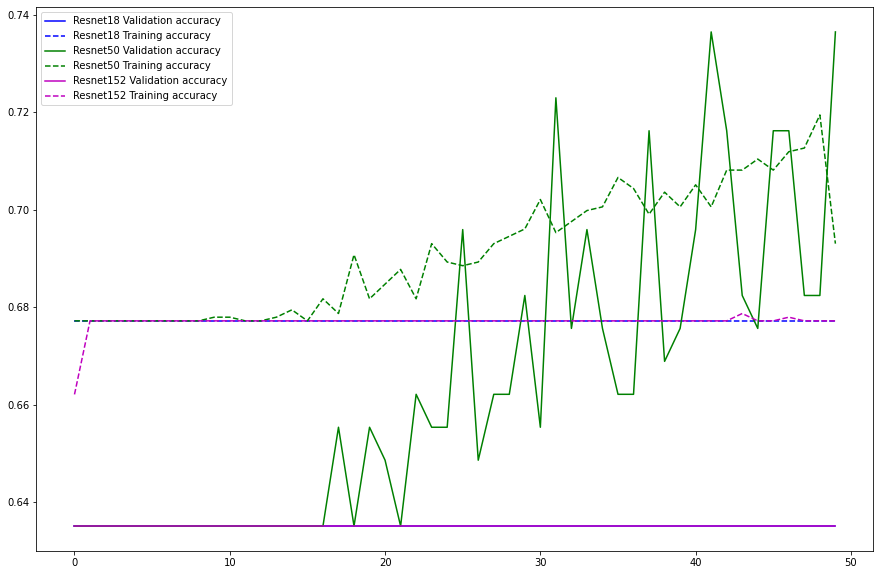

In [16]:
# Plotting traning and validation performance

b_train_acc = []
for val in balanced_tr_hist:
  b_train_acc.append(val.cpu().data.numpy())

b_val_acc = []
for val in balanced_val_hist:
  b_val_acc.append(val.cpu().data.numpy())

b_train_acc2 = []
for val in balanced_tr_hist2:
  b_train_acc2.append(val.cpu().data.numpy())

b_val_acc2 = []
for val in balanced_val_hist2:
  b_val_acc2.append(val.cpu().data.numpy())

b_train_acc3 = []
for val in balanced_tr_hist3:
  b_train_acc3.append(val.cpu().data.numpy())

b_val_acc3 = []
for val in balanced_val_hist3:
  b_val_acc3.append(val.cpu().data.numpy())

# im_train_acc = []
# for val in imbalanced_tr_hist:
#   im_train_acc.append(val.cpu().data.numpy())

# im_val_acc = []
# for val in imbalanced_val_hist:
#   im_val_acc.append(val.cpu().data.numpy())
plt.figure(figsize=(15,10))
plt.plot(b_val_acc, 'b-', label='Resnet18 Validation accuracy')
plt.plot(b_train_acc,'b--', label='Resnet18 Training accuracy')
plt.plot(b_val_acc2, 'g-', label='Resnet50 Validation accuracy')
plt.plot(b_train_acc2,'g--', label='Resnet50 Training accuracy')
plt.plot(b_val_acc3, 'm-', label='Resnet152 Validation accuracy')
plt.plot(b_train_acc3,'m--', label='Resnet152 Training accuracy')
plt.legend()
plt.show()

In [20]:
test_path_data = 'drive/MyDrive/balanced_csic_data_128/testing'
testing_dataset = torchvision.datasets.ImageFolder(test_path_data, transform=transform)
batch_size = 32
testing_dataloader =torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(testing_dataset.class_to_idx)


{'Cyperus': 0, 'Negative': 1, 'Portulaca': 2, 'Solanum': 3}


In [21]:
def getTestingMatrics(dataloader, model):
  # send model to GPU
  if torch.cuda.is_available():
    model.cuda()

  # with tqdm(testing_dataloader) as tepoch:
  lbs = []
  preds = []
  #   # Iterate over data.
  for inputs, labels in dataloader:
    test_inputs = inputs.to(device)
    #test_labels = labels.to(device)
    outputs = model(test_inputs)
    _, pred = torch.max(outputs, 1)
    lbs+=(list(labels.numpy()))
    preds+= list(pred.cpu().data.numpy())
  print('Overall testing accuracy:',accuracy_score(lbs, preds))
  print(classification_report(lbs, preds, target_names=class_dict.keys()))

In [22]:
getTestingMatrics(testing_dataloader, model_ft_balanced)
getTestingMatrics(testing_dataloader, model_ft_balanced2)
getTestingMatrics(testing_dataloader, model_ft_balanced3)


Overall testing accuracy: 0.2564102564102564
              precision    recall  f1-score   support

     Cyperus       0.26      1.00      0.41        40
    Negative       0.00      0.00      0.00        40
   Portulaca       0.00      0.00      0.00        40
     Solanum       0.00      0.00      0.00        36

    accuracy                           0.26       156
   macro avg       0.06      0.25      0.10       156
weighted avg       0.07      0.26      0.10       156



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall testing accuracy: 0.33974358974358976
              precision    recall  f1-score   support

     Cyperus       0.30      0.93      0.45        40
    Negative       0.82      0.23      0.35        40
   Portulaca       0.00      0.00      0.00        40
     Solanum       0.32      0.19      0.24        36

    accuracy                           0.34       156
   macro avg       0.36      0.34      0.26       156
weighted avg       0.36      0.34      0.26       156



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall testing accuracy: 0.2564102564102564
              precision    recall  f1-score   support

     Cyperus       0.26      1.00      0.41        40
    Negative       0.00      0.00      0.00        40
   Portulaca       0.00      0.00      0.00        40
     Solanum       0.00      0.00      0.00        36

    accuracy                           0.26       156
   macro avg       0.06      0.25      0.10       156
weighted avg       0.07      0.26      0.10       156



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
